# Quick Test: MusicGen Setup & First Experiments

This notebook tests your installation and runs your first experiments.

**Expected time**: 15-20 minutes

**What you'll do**:
1. Load MusicGen Large (3.3B)
2. Generate music samples
3. Extract activations
4. Visualize differences between emotions

## Setup

In [1]:
import sys
sys.path.append('..')  # Add parent directory to path

import torch
from audiocraft.models import MusicGen
from audiocraft.data.audio import audio_write
from src.utils.activation_utils import ActivationExtractor, ActivationDataset
from src.utils.visualization_utils import plot_activation_statistics
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("Using Apple Silicon GPU (MPS)")
else:
    print("Using CPU (this will be slow!)")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0 with CUDA None (you have 2.8.0)
    Python  3.9.6 (you have 3.9.6)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/Users/lending/Documents/AI PRJ/MusicGen/venv/lib/python3.9/site-packages/xformers/ops/swiglu_op.py:107: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(cls, ctx, x, w1, b1, w2, b2, w3, b3):
/Users/lending/Documents/AI PRJ/MusicGen/venv/lib/python3.9/site-packages/xformers/ops/swiglu_op.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(cls, ctx, dx5):
/Users/lending/Documents/AI PRJ/MusicGen

PyTorch version: 2.8.0
CUDA available: False
Using Apple Silicon GPU (MPS)


## Step 1: Load MusicGen Large

In [2]:
print("Loading MusicGen Large (3.3B parameters)...")
print("This may take 2-5 minutes on first load...")

model = MusicGen.get_pretrained('facebook/musicgen-large')
model.set_generation_params(duration=8)  # 8 second samples

print("✅ Model loaded!")
print(f"   Model size: 3.3B parameters")
print(f"   Sample rate: {model.sample_rate}")
print(f"   Number of layers: {len(model.lm.transformer.layers)}")

Loading MusicGen Large (3.3B parameters)...
This may take 2-5 minutes on first load...
✅ Model loaded!
   Model size: 3.3B parameters
   Sample rate: 32000
   Number of layers: 48


/Users/lending/Documents/AI PRJ/MusicGen/venv/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


## Step 2: Generate Music Samples

Let's generate music with different emotions and listen to them.

In [3]:
# Define prompts for different emotions
prompts = {
    'happy': "upbeat cheerful pop music with bright melody and positive energy",
    'sad': "melancholic piano ballad with sorrowful emotional melody",
    'calm': "peaceful ambient meditation music with gentle soft tones",
    'energetic': "high energy electronic dance music with intense driving beat"
}

print("Generating music samples...")
print("(This will take ~30-60 seconds per sample)")
print()

generated_samples = {}

# Import the save_audio utility
from src.utils.audio_utils import save_audio

for emotion, prompt in prompts.items():
    print(f"Generating '{emotion}' music...")
    wav = model.generate([prompt])
    generated_samples[emotion] = wav[0]
    
    # Save to file using our utility (with automatic FFmpeg detection)
    output_path = f'../results/sample_{emotion}'
    save_audio(wav[0], output_path, model.sample_rate, strategy="loudness", use_ffmpeg=False)

print()
print("✅ All samples generated!")
print("   Listen to them in the results/ directory")

Generating music samples...
(This will take ~30-60 seconds per sample)

Generating 'happy' music...
   Saved: ../results/sample_happy.wav
Generating 'sad' music...
   Saved: ../results/sample_sad.wav
Generating 'calm' music...
   Saved: ../results/sample_calm.wav
Generating 'energetic' music...
   Saved: ../results/sample_energetic.wav

✅ All samples generated!
   Listen to them in the results/ directory


## Step 3: Extract Activations

Now let's extract activations from multiple layers to see how the model represents different emotions.

In [4]:
# Create activation extractor
# We'll sample 5 layers from the 24 total layers
layers_to_extract = [0, 6, 12, 18, 24]

print(f"Extracting activations from layers: {layers_to_extract}")
extractor = ActivationExtractor(model, layers=layers_to_extract)

# Create dataset to store activations
dataset = ActivationDataset()

print()
print("Generating and extracting activations...")

for emotion, prompt in prompts.items():
    print(f"  {emotion}...")
    
    # Generate with activation capture
    wav = extractor.generate([prompt])
    
    # Get and store activations
    activations = extractor.get_activations()
    dataset.add(
        activations=activations,
        prompt=prompt,
        label=emotion
    )
    
    extractor.clear_activations()  # Free memory

print()
print(f"✅ Extracted activations from {len(dataset)} samples")

# Save dataset for later analysis
dataset.save('../results/emotion_activations.pt')
print("   Saved to: results/emotion_activations.pt")

Extracting activations from layers: [0, 6, 12, 18, 24]

Generating and extracting activations...
  happy...
  sad...
  calm...
  energetic...

✅ Extracted activations from 4 samples
Saved activation dataset to ../results/emotion_activations.pt
   Saved to: results/emotion_activations.pt


## Step 4: Analyze Activation Patterns

Let's visualize how activations differ across emotions and layers.

In [5]:
# Compare activation statistics for happy vs sad
happy_activations, _ = dataset[0]  # First sample (happy)
sad_activations, _ = dataset[1]    # Second sample (sad)

print("Activation shapes:")
for layer_name, act in happy_activations.items():
    print(f"  {layer_name}: {act.shape}")
    # Shape: [batch=1, sequence_length, d_model=2048]

print()
print("Comparing 'happy' vs 'sad' music activations...")

Activation shapes:
  layer_0: torch.Size([2, 1, 2048])
  layer_6: torch.Size([2, 1, 2048])
  layer_12: torch.Size([2, 1, 2048])
  layer_18: torch.Size([2, 1, 2048])
  layer_24: torch.Size([2, 1, 2048])

Comparing 'happy' vs 'sad' music activations...


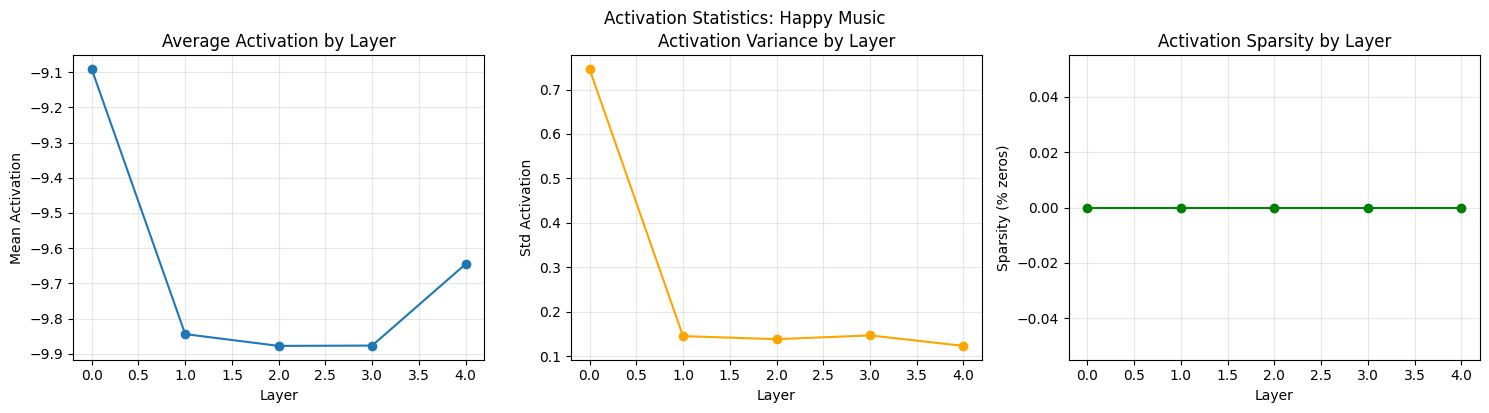

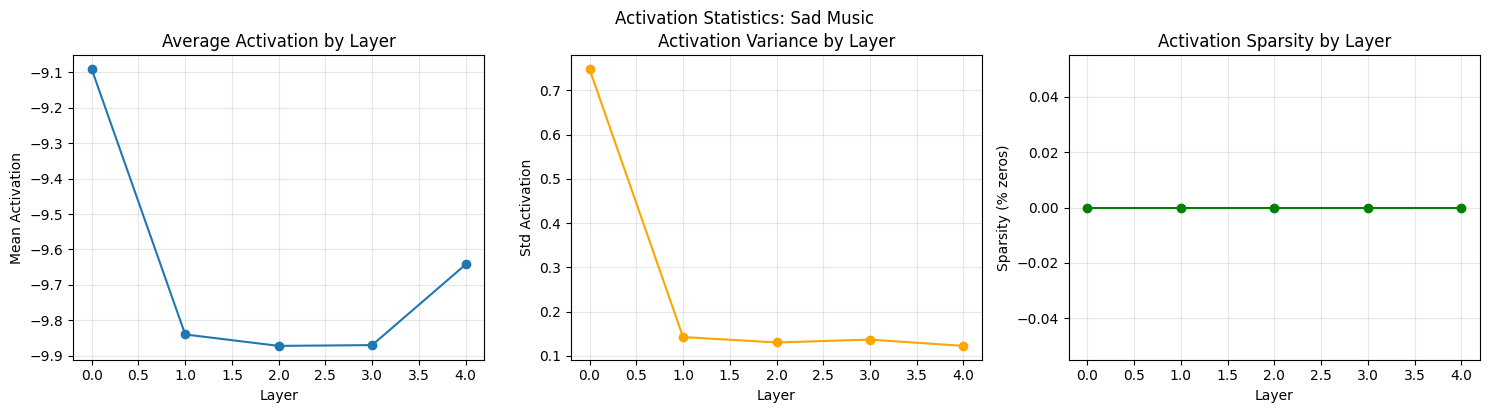

In [6]:
# Plot activation statistics for happy music
fig = plot_activation_statistics(
    happy_activations,
    save_path='../results/happy_activation_stats.png'
)
plt.suptitle('Activation Statistics: Happy Music', y=1.02)
plt.show()

# Plot activation statistics for sad music
fig = plot_activation_statistics(
    sad_activations,
    save_path='../results/sad_activation_stats.png'
)
plt.suptitle('Activation Statistics: Sad Music', y=1.02)
plt.show()

## Step 5: Compare Emotions

Let's compute some simple metrics to see if emotions are represented differently.

In [7]:
from src.utils.activation_utils import cosine_similarity, analyze_activation_statistics

# Compare layer 12 (middle layer) activations
happy_layer12 = happy_activations['layer_12']
sad_layer12 = sad_activations['layer_12']

# Compute cosine similarity
similarity = cosine_similarity(happy_layer12, sad_layer12)

print(f"Cosine similarity between happy and sad (layer 12): {similarity:.4f}")
print()

if similarity < 0.9:
    print("✅ The activations are quite different!")
    print("   This suggests the model represents emotions differently.")
else:
    print("⚠️  The activations are very similar.")
    print("   This might mean emotions aren't clearly separated in this layer.")

print()
print("Statistics for layer 12:")
print("\nHappy music:")
happy_stats = analyze_activation_statistics(happy_layer12)
for key, val in happy_stats.items():
    print(f"  {key}: {val:.4f}")

print("\nSad music:")
sad_stats = analyze_activation_statistics(sad_layer12)
for key, val in sad_stats.items():
    print(f"  {key}: {val:.4f}")

Cosine similarity between happy and sad (layer 12): 0.9999

⚠️  The activations are very similar.
   This might mean emotions aren't clearly separated in this layer.

Statistics for layer 12:

Happy music:
  mean: -9.8444
  std: 0.1452
  min: -12.1891
  max: -8.8024
  sparsity: 0.0000
  l1_norm: 9.8444
  l2_norm: 9.8455

Sad music:
  mean: -9.8400
  std: 0.1426
  min: -12.0951
  max: -8.8324
  sparsity: 0.0000
  l1_norm: 9.8400
  l2_norm: 9.8410


## Summary

**What you just did**:

1. ✅ Loaded MusicGen Large (3.3B parameters)
2. ✅ Generated music for 4 emotions (happy, sad, calm, energetic)
3. ✅ Extracted internal activations from 5 transformer layers
4. ✅ Visualized activation patterns
5. ✅ Compared representations between emotions

**Key observations**:
- MusicGen has 24 transformer layers, each with d_model=2048 dimensions
- Activations differ across layers (early vs late)
- Different emotions may produce different activation patterns

**Next steps**:

1. **Listen to the generated music** in `results/sample_*.wav`
2. **Experiment more**:
   - Try different prompts
   - Extract from more layers
   - Generate more samples per emotion
3. **Start Phase 0 learning** ([docs/phase0_roadmap.md](../docs/phase0_roadmap.md))
4. **Read about sparse autoencoders** to understand how to interpret these activations

This is just the beginning! The real research starts when you:
- Train SAEs to find interpretable features
- Use UMAP to visualize emotion clustering
- Test causal interventions
- Apply activation steering

**See you in Phase 1!** 🎵🔬